[Source for tutorial](https://github.com/pgmpy/pgmpy/blob/dev/examples/Alarm.ipynb)


# Alarm Bayesian Network
Creating the Alarm Bayesian network using pgmpy and doing some simple queries (mentioned in Bayesian Artificial Intelligence, Section 2.5.1: )

Doing path-setting:

In [1]:
import os
import sys
from typing import *
from typing import Union, List, Any

import itertools

os.getcwd()
# Setting the baseline:
os.chdir('/development/projects/statisticallyfit/github/learningmathstat/PythonProbabilisticGraphicalModels')


curPath: str = os.getcwd() + "/src/PgmpyStudy/"

dataPath: str = curPath + "data/"

imagePath: str = curPath + 'images/'

print("curPath = ", curPath, "\n")
print("dataPath = ", dataPath, "\n")
print('imagePath = ', imagePath, "\n")


# Making files in utils folder visible here: to import my local print functions for nn.Module objects
sys.path.append(os.getcwd() + "/src/utils/")
# For being able to import files within PgmpyStudy folder
sys.path.append(curPath)

#sys.path.remove('/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/utils/')
#sys.path.remove('/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/')

sys.path

curPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonProbabilisticGraphicalModels/src/PgmpyStudy/ 

dataPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonProbabilisticGraphicalModels/src/PgmpyStudy/data/ 

imagePath =  /development/projects/statisticallyfit/github/learningmathstat/PythonProbabilisticGraphicalModels/src/PgmpyStudy/images/ 



['/development/projects/statisticallyfit/github/learningmathstat/PythonProbabilisticGraphicalModels/src/PgmpyStudy',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python37.zip',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/lib-dynload',
 '',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/IPython/extensions',
 '/home/statisticallyfit/.ipython',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonProbabilisticGraphicalModels/src/utils/',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonProbabilisticGraphicalModels/src/PgmpyStudy/']

Science imports:

In [2]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.factors.discrete import JointProbabilityDistribution
from pgmpy.factors.discrete.DiscreteFactor import DiscreteFactor
from pgmpy.independencies import Independencies
from pgmpy.independencies.Independencies import IndependenceAssertion


from operator import mul
from functools import reduce


from src.utils.GraphvizUtil import *
from src.utils.NetworkUtil import *

## Problem Statement: 2.5.1 Earthquake Alarm
**Example statement:** You have a new burglar alarm installed. It reliably detects burglary, but also responds to minor earthquakes. Two neighbors, John and Mary, promise to call the police when they hear the alarm. John always calls when he hears the alarm, but sometimes confuses the alarm with the phone ringing and calls then also. On the other hand, Mary likes loud music and sometimes doesn't hear the alarm. Given evidence about who has and hasn't called, you'd like to estimate the probability of a burglary alarm (from Pearl (1988)).


In [3]:

import collections

# Creating some names for the random variables (nodes) in the graph, to clarify meaning.

# Create named tuple class with names "Names" and "Objects"
RandomVariable = collections.namedtuple("RandomVariable", ["var", "states"])

Burglary = RandomVariable(var = "Burglary", states = ['True', 'False'])
Earthquake = RandomVariable(var = "Earthquake", states = ['True', 'False'])
Alarm = RandomVariable(var = "Alarm", states = ['True', 'False'])
JohnCalls = RandomVariable(var = "JohnCalls", states = ['True', 'False'])
MaryCalls = RandomVariable(var = "MaryCalls", states = ['True', 'False'])

#Burglary: Dict[Variable, List[State]] = {Burglary.var: ['True', 'False']}
#Earthquake: Dict[Variable, List[State]] = {Earthquake.var: ['True', 'False']}
#Alarm: Dict[Variable, List[State]] = {Alarm.var: ['True', 'False']}
#JohnCalls: Dict[Variable, List[State]] = {JohnCalls.var: ['True', 'False']}
#MaryCalls: Dict[Variable, List[State]] = {MaryCalls.var: ['True', 'False']}


# Defining the network structure:
#alarmModel: BayesianModel = BayesianModel([(Burglary.variable, Alarm.variable),
#                                           (Earthquake.variable, Alarm.variable),
#                                           (Alarm.variable, JohnCalls.variable),
#                                           (Alarm.variable, MaryCalls.variable)])

alarmModel: BayesianModel = BayesianModel([(Burglary.var, Alarm.var),
                                          (Earthquake.var, Alarm.var),
                                          (Alarm.var, JohnCalls.var),
                                          (Alarm.var, MaryCalls.var)])

# Defining parameters using CPT

cpdBurglary: TabularCPD = TabularCPD(variable = Burglary.var, variable_card = len(Burglary.states),
                                     values = [[0.001, 0.999]],
                                     state_names = {Burglary.var : Burglary.states})

print(cpdBurglary)

+-----------------+-------+
| Burglary(True)  | 0.001 |
+-----------------+-------+
| Burglary(False) | 0.999 |
+-----------------+-------+


In [4]:
cpdEarthquake: TabularCPD = TabularCPD(variable = Earthquake.var,
                                       variable_card = len(Earthquake.states),
                                       values = [[0.002, 0.998]],
                                       state_names = {Earthquake.var : Earthquake.states})

print(cpdEarthquake)

+-------------------+-------+
| Earthquake(True)  | 0.002 |
+-------------------+-------+
| Earthquake(False) | 0.998 |
+-------------------+-------+


In [5]:
cpdAlarm: TabularCPD = TabularCPD(variable = Alarm.var,
                                  variable_card = len(Alarm.states),
                                  values = [[0.95, 0.94, 0.29, 0.001],
                                            [0.05, 0.06, 0.71, 0.999]],
                                  evidence = [Burglary.var, Earthquake.var],
                                  evidence_card = [len(Burglary.states), len(Earthquake.states)],
                                  state_names = {Alarm.var: Alarm.states,
                                                 Burglary.var : Burglary.states,
                                                 Earthquake.var : Earthquake.states})
print(cpdAlarm)


#def toDict(tup: RandomVariable):
#    return {tup.var : tup.states}

+--------------+------------------+-------------------+------------------+-------------------+
| Burglary     | Burglary(True)   | Burglary(True)    | Burglary(False)  | Burglary(False)   |
+--------------+------------------+-------------------+------------------+-------------------+
| Earthquake   | Earthquake(True) | Earthquake(False) | Earthquake(True) | Earthquake(False) |
+--------------+------------------+-------------------+------------------+-------------------+
| Alarm(True)  | 0.95             | 0.94              | 0.29             | 0.001             |
+--------------+------------------+-------------------+------------------+-------------------+
| Alarm(False) | 0.05             | 0.06              | 0.71             | 0.999             |
+--------------+------------------+-------------------+------------------+-------------------+


In [6]:
cpdJohnCalls: TabularCPD = TabularCPD(variable = JohnCalls.var, variable_card = len(JohnCalls.states),
                                      values = [[0.90, 0.05],
                                                [0.10, 0.95]],
                                      evidence = [Alarm.var], evidence_card = [len(Alarm.states)],
                                      state_names = {JohnCalls.var : JohnCalls.states,
                                                     Alarm.var : Alarm.states})
print(cpdJohnCalls)

+------------------+-------------+--------------+
| Alarm            | Alarm(True) | Alarm(False) |
+------------------+-------------+--------------+
| JohnCalls(True)  | 0.9         | 0.05         |
+------------------+-------------+--------------+
| JohnCalls(False) | 0.1         | 0.95         |
+------------------+-------------+--------------+


In [7]:
cpdMaryCalls: TabularCPD = TabularCPD(variable = MaryCalls.var, variable_card = len(MaryCalls.states),
                                      values = [[0.70, 0.01],
                                                [0.30, 0.99]],
                                      evidence = [Alarm.var], evidence_card = [len(Alarm.states)],
                                      state_names = {MaryCalls.var: MaryCalls.states,
                                                     Alarm.var : Alarm.states})
print(cpdMaryCalls)

+------------------+-------------+--------------+
| Alarm            | Alarm(True) | Alarm(False) |
+------------------+-------------+--------------+
| MaryCalls(True)  | 0.7         | 0.01         |
+------------------+-------------+--------------+
| MaryCalls(False) | 0.3         | 0.99         |
+------------------+-------------+--------------+


In [8]:
alarmModel.add_cpds(cpdBurglary, cpdEarthquake, cpdAlarm, cpdJohnCalls, cpdMaryCalls)

assert alarmModel.check_model()

Making a brief-name version for viewing clarity, in tables:

In [9]:
alarmModel_brief: BayesianModel = BayesianModel([(Burglary.var[0], Alarm.var[0]),
                                          (Earthquake.var[0], Alarm.var[0]),
                                          (Alarm.var[0], JohnCalls.var[0]),
                                          (Alarm.var[0], MaryCalls.var[0])])

# Defining parameters using CPT

cpdBurglary: TabularCPD = TabularCPD(variable = Burglary.var[0], variable_card = len(Burglary.states),
                                     values = [[0.001, 0.999]],
                                     state_names = {Burglary.var[0] : Burglary.states})


cpdEarthquake: TabularCPD = TabularCPD(variable = Earthquake.var[0],
                                       variable_card = len(Earthquake.states),
                                       values = [[0.002, 0.998]],
                                       state_names = {Earthquake.var[0] : Earthquake.states})


cpdAlarm: TabularCPD = TabularCPD(variable = Alarm.var[0],
                                  variable_card = len(Alarm.states),
                                  values = [[0.95, 0.94, 0.29, 0.001],
                                            [0.05, 0.06, 0.71, 0.999]],
                                  evidence = [Burglary.var[0], Earthquake.var[0]],
                                  evidence_card = [len(Burglary.states), len(Earthquake.states)],
                                  state_names = {Alarm.var[0]: Alarm.states,
                                                 Burglary.var[0] : Burglary.states,
                                                 Earthquake.var[0] : Earthquake.states})

cpdJohnCalls: TabularCPD = TabularCPD(variable = JohnCalls.var[0], variable_card = len(JohnCalls.states),
                                      values = [[0.90, 0.05],
                                                [0.10, 0.95]],
                                      evidence = [Alarm.var[0]], evidence_card = [len(Alarm.states)],
                                      state_names = {JohnCalls.var[0] : JohnCalls.states,
                                                     Alarm.var[0] : Alarm.states})

cpdMaryCalls: TabularCPD = TabularCPD(variable = MaryCalls.var[0], variable_card = len(MaryCalls.states),
                                      values = [[0.70, 0.01],
                                                [0.30, 0.99]],
                                      evidence = [Alarm.var[0]], evidence_card = [len(Alarm.states)],
                                      state_names = {MaryCalls.var[0]: MaryCalls.states,
                                                     Alarm.var[0] : Alarm.states})

alarmModel_brief.add_cpds(cpdBurglary, cpdEarthquake, cpdAlarm, cpdJohnCalls, cpdMaryCalls)

assert alarmModel_brief.check_model()

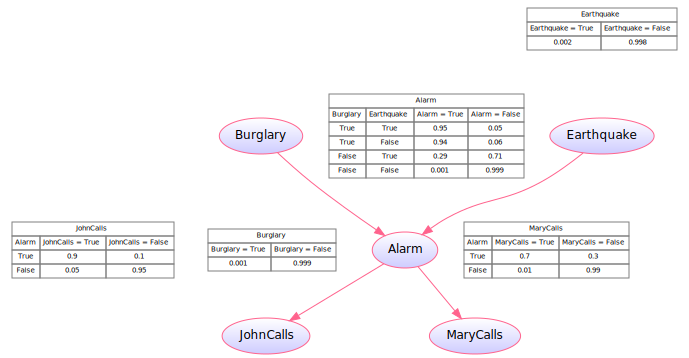

In [10]:
pgmpyToGraphCPD(model = alarmModel, shorten = False)

## 1/ Independencies of the Alarm Model

In [11]:
alarmModel.local_independencies(Burglary.var)

(Burglary _|_ Earthquake)

In [12]:
alarmModel.local_independencies(Earthquake.var)

(Earthquake _|_ Burglary)

In [13]:
alarmModel.local_independencies(Alarm.var)

In [14]:
print(alarmModel.local_independencies(MaryCalls.var))

indepSynonymTable(model = alarmModel, queryNode = MaryCalls.var)

(MaryCalls _|_ Earthquake, JohnCalls, Burglary | Alarm)
                                                       INDEPENDENCIES TABLE                                                      
Fancy Notation                                                  .....     Regular Notation                                       
---------------------------------------------------------------------------------------------------------------------------------
(MaryCalls _|_ {Earthquake ∩ JohnCalls ∩ Burglary} | Alarm)     .....     (MaryCalls _|_ Earthquake, JohnCalls, Burglary | Alarm)
(MaryCalls _|_ {Earthquake ∩ Burglary ∩ JohnCalls} | Alarm)     .....     (MaryCalls _|_ Earthquake, Burglary, JohnCalls | Alarm)
(MaryCalls _|_ {JohnCalls ∩ Earthquake ∩ Burglary} | Alarm)     .....     (MaryCalls _|_ JohnCalls, Earthquake, Burglary | Alarm)
(MaryCalls _|_ {JohnCalls ∩ Burglary ∩ Earthquake} | Alarm)     .....     (MaryCalls _|_ JohnCalls, Burglary, Earthquake | Alarm)
(MaryCalls _|_ {Burglary ∩ Earthqu

In [15]:
print(alarmModel.local_independencies(JohnCalls.var))

indepSynonymTable(model = alarmModel, queryNode = JohnCalls.var)

(JohnCalls _|_ Earthquake, MaryCalls, Burglary | Alarm)
                                                       INDEPENDENCIES TABLE                                                      
Fancy Notation                                                  .....     Regular Notation                                       
---------------------------------------------------------------------------------------------------------------------------------
(JohnCalls _|_ {Earthquake ∩ MaryCalls ∩ Burglary} | Alarm)     .....     (JohnCalls _|_ Earthquake, MaryCalls, Burglary | Alarm)
(JohnCalls _|_ {Earthquake ∩ Burglary ∩ MaryCalls} | Alarm)     .....     (JohnCalls _|_ Earthquake, Burglary, MaryCalls | Alarm)
(JohnCalls _|_ {MaryCalls ∩ Earthquake ∩ Burglary} | Alarm)     .....     (JohnCalls _|_ MaryCalls, Earthquake, Burglary | Alarm)
(JohnCalls _|_ {MaryCalls ∩ Burglary ∩ Earthquake} | Alarm)     .....     (JohnCalls _|_ MaryCalls, Burglary, Earthquake | Alarm)
(JohnCalls _|_ {Burglary ∩ Earthqu

In [16]:
alarmModel.get_independencies()



(Burglary _|_ Earthquake)
(Burglary _|_ JohnCalls, MaryCalls | Alarm)
(Burglary _|_ JohnCalls, MaryCalls | Earthquake, Alarm)
(Burglary _|_ MaryCalls | JohnCalls, Alarm)
(Burglary _|_ JohnCalls | MaryCalls, Alarm)
(Burglary _|_ MaryCalls | Earthquake, JohnCalls, Alarm)
(Burglary _|_ JohnCalls | MaryCalls, Earthquake, Alarm)
(Earthquake _|_ Burglary)
(Earthquake _|_ JohnCalls, MaryCalls | Alarm)
(Earthquake _|_ MaryCalls | JohnCalls, Alarm)
(Earthquake _|_ JohnCalls | MaryCalls, Alarm)
(Earthquake _|_ JohnCalls, MaryCalls | Alarm, Burglary)
(Earthquake _|_ MaryCalls | JohnCalls, Alarm, Burglary)
(Earthquake _|_ JohnCalls | MaryCalls, Alarm, Burglary)
(JohnCalls _|_ Earthquake, MaryCalls, Burglary | Alarm)
(JohnCalls _|_ MaryCalls, Burglary | Earthquake, Alarm)
(JohnCalls _|_ Earthquake, Burglary | MaryCalls, Alarm)
(JohnCalls _|_ Earthquake, MaryCalls | Alarm, Burglary)
(JohnCalls _|_ Burglary | MaryCalls, Earthquake, Alarm)
(JohnCalls _|_ MaryCalls | Earthquake, Alarm, Burglary)
(JohnC

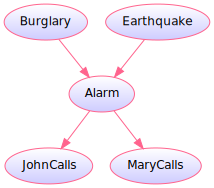

In [17]:
# TODO say direct dependency assumptions (from Korb book)

pgmpyToGraph(alarmModel)

### Study: Independence Maps (I-Maps)
* **Markov Assumption:** Bayesian networks require the assumption of **Markov Property**: that there are no direct dependencies in the system being modeled, which are not already explicitly shown via arcs. (In the earthquake example, this translates to saying there is no way for an `Earthquake` to influence `MaryCalls` except by way of the `Alarm`.  There is no **hidden backdoor** from  `Earthquake` to `MaryCalls`).
* **I-maps:** Bayesian networks which have this **Markov property** are called **Independence-maps** or **I-maps**, since every independence suggested by the lack of an arc is actual a valid, real independence in the system.

Source: Korb book, Bayesian Artificial Intelligence (section 2.2.4)

### Example 1: I-map
Testing meaning of an **I-map** using a simple student example

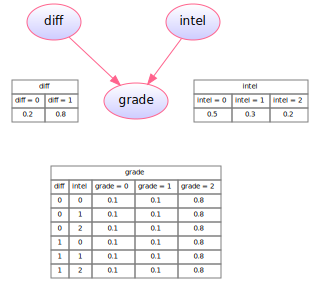

In [18]:
Difficulty: RandomVariable = RandomVariable(var = 'diff', states = ['Easy', 'Hard'])
Grade: RandomVariable = RandomVariable(var = 'grade', states = ['Good', 'Medium', 'Bad'])
Intelligence: RandomVariable = RandomVariable(var = 'intel', states = ['Dumb', 'Average', 'Intelligent'])


gradeModel = BayesianModel([(Difficulty.var, Grade.var), (Intelligence.var, Grade.var)])

diff_cpd = TabularCPD(variable = Difficulty.var, variable_card = len(Difficulty.states),
                      values = [[0.2], [0.8]])

intel_cpd = TabularCPD(variable = Intelligence.var, variable_card = len(Intelligence.states),
                       values = [[0.5], [0.3], [0.2]])

grade_cpd = TabularCPD(variable = Grade.var, variable_card = len(Grade.states),
                       values = [[0.1,0.1,0.1,0.1,0.1,0.1],
                                    [0.1,0.1,0.1,0.1,0.1,0.1],
                                    [0.8,0.8,0.8,0.8,0.8,0.8]],
                       evidence=[Difficulty.var, Intelligence.var],
                       evidence_card=[len(Difficulty.states), len(Intelligence.states)])

gradeModel.add_cpds(diff_cpd, intel_cpd, grade_cpd)


pgmpyToGraphCPD(gradeModel)

Showing two ways of creating the `JointProbabilityDistribution`    : (1) by feeding in values manually, or (2) by using `reduce` over the `TabularCPD`s or `DiscreteFactor`s.

In [19]:
# Method 1: Creating joint distribution manually, by feeding in the calculated values:
jpdValues = [0.01, 0.01, 0.08, 0.006, 0.006, 0.048, 0.004, 0.004, 0.032,
           0.04, 0.04, 0.32, 0.024, 0.024, 0.192, 0.016, 0.016, 0.128]

JPD = JointProbabilityDistribution(variables = [Difficulty.var , Intelligence.var, Grade.var],
                                   cardinality = [len(Difficulty.states), len(Intelligence.states), len(Grade.states)], values = jpdValues)

print(JPD)

+---------+----------+----------+-----------------------+
| diff    | intel    | grade    |   P(diff,intel,grade) |
+=========+==========+==========+=======================+
| diff(0) | intel(0) | grade(0) |                0.0100 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(0) | grade(1) |                0.0100 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(0) | grade(2) |                0.0800 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(0) |                0.0060 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(1) |                0.0060 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(2) |                0.0480 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(2) | grade(0) |                0.0040 |
+---------+----------+----------+-----------------------+
| diff(0) | in

Showing if small student model is I-map:

In [20]:
from src.utils.NetworkUtil import *


# Method 2: creating the JPD by multiplying over the TabularCPDs (as per formula in page 16 of pgmpy book, Ankur Ankan)
gradeJPDFactor: DiscreteFactor = DiscreteFactor(variables = JPD.variables, cardinality =  JPD.cardinality, values = JPD.values)
gradeJPD: JointProbabilityDistribution = jointDistribution(gradeModel)


assert gradeModel.is_imap(JPD = JPD), "Check: using JPD to verify the graph is an independence-map: means no hidden backdoors between nodes and no way for variables to influence others except by one path"

assert gradeJPD == gradeJPDFactor, "Check: joint distribution is the same as multiplying the cpds"

Grade model's `JointProbabilityDistribution` over all variables:

In [21]:
print(gradeJPD)

+---------+----------+----------+-----------------------+
| diff    | intel    | grade    |   P(diff,intel,grade) |
+=========+==========+==========+=======================+
| diff(0) | intel(0) | grade(0) |                0.0100 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(0) | grade(1) |                0.0100 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(0) | grade(2) |                0.0800 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(0) |                0.0060 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(1) |                0.0060 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(2) |                0.0480 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(2) | grade(0) |                0.0040 |
+---------+----------+----------+-----------------------+
| diff(0) | in

Checking if alarm model is I-map:

In [22]:
alarmJPD: JointProbabilityDistribution = jointDistribution(alarmModel_brief)

assert not alarmModel_brief.is_imap(JPD = alarmJPD)





## 3/ Joint Distribution Represented by the Bayesian Network
Computing the Joint Distribution from the Bayesian Network, `model`:

From the **chain rule of probability (also called and rule):**
$$
P(A, B) = P(B) \cdot P(A \; | \; B)
$$
Now in this case for the `alarmModel`:
$$
\begin{array}{ll}
P(J, M, A, E, B)
&= P(J \; | \; M, A, E, B) \cdot P(J, M, A, E, B) \\
&= P(J \; | \; M, A, E, B) \cdot {\color{cyan} (} P(M \; | \; A,E,B) \cdot P(A,E,B) {\color{cyan} )} \\
&=  P(J \; | \; M, A, E, B) \cdot  P(M \; | \; A,E,B) \cdot {\color{cyan} (}P(A \; | \; E,B) \cdot P(E, B){\color{cyan} )} \\
&= P(J \; | \; M, A, E, B) \cdot  P(M \; | \; A,E,B) \cdot P(A \; | \; E,B) \cdot {\color{cyan} (}P(E \; | \; B) \cdot P(B){\color{cyan} )} \\
\end{array}
$$

In [23]:
probChainRule(['J','M','A','E','B'])

'P(J | M, A, E, B) * P(M | A, E, B) * P(A | E, B) * P(E | B) * P(B)'

Alarm model's `JointProbabilityDistribution` over all variables

In [24]:
print(alarmJPD)




+------+------+------+------+------+----------------+
| B    | E    | A    | J    | M    |   P(B,E,A,J,M) |
+======+======+======+======+======+================+
| B(0) | E(0) | A(0) | J(0) | M(0) |         0.0000 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(0) | J(0) | M(1) |         0.0000 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(0) | J(1) | M(0) |         0.0000 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(0) | J(1) | M(1) |         0.0000 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(1) | J(0) | M(0) |         0.0000 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(1) | J(0) | M(1) |         0.0000 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(1) | J(1) | M(0) |         0.0000 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(1) | J(1) | M(1) |         0.0000 |
+------+------+------+------

## 4/ Inference in Bayesian Alarm Model

Now let us do inference in a  Bayesian model and predict values using this model over new data points for ML tasks.

### 1. Causal Reasoning in the Alarm Model
For a causal model $A \rightarrow B \rightarrow C$, there are two cases:
  * **Marginal Dependence:** ($B$ unknown): When $B$ is unknown / unobserved, there is an active trail between $A$ and $C$, meaning the probability of $A$ can influence probability of $C$ (and vice versa).
  * **Conditional Independence:** ($B$ fixed): When $B$ is fixed, there is NO active trail between $A$ and $C$, so they are independent, which means the probability of $A$ won't influence probability of $C$ (and vice versa).

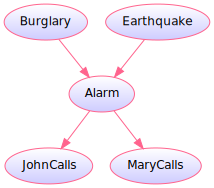

In [25]:
pgmpyToGraph(alarmModel)

### Case 1: Marginal Dependence (for Causal Model)
For a causal model $A \rightarrow B \rightarrow C$, when the state of the middle node $B$ is unobserved, then an active trail is created between the nodes, namely the active trail is $A \rightarrow B \rightarrow C$. Information can now flow from node $A$ to node $C$ via node $B$. This implies there is a dependency between nodes $A$ and $C$, so the probability of $A$ taking on any of its states can influence the probability of $C$ taking on any of its states. This is called **marginal dependence** We can write this as: $P(A | C) \ne P(A)$

$\color{red}{\text{TODO}}$ left off here trying to refactor the text (continue from sublime notes pg 35 Korb and pg 336 Bayesiabook)
$$
\color{Green}{ \text{Alarm (unobserved): }\;\;\;\;\;\;\;\;\; \text{Burglary} \longrightarrow \text{Alarm} \longrightarrow \text{MaryCalls}}
$$

Given that the state of `Alarm` is unobserved, we can state the following equivalent statements:
* there IS an active trail between `Burglary` and `MaryCalls`.
* the random variables `Burglary` and `MaryCalls` are dependent.
* the probability of `Burglary` can influence probability of `MaryCalls` (and vice versa).

Similarly, the same kinds of statements can be made for the other causal chain pathways in the graph:

$$
\color{Green}{ \text{Alarm (unobserved): }\;\;\;\;\;\;\;\;\; \text{Burglary} \longrightarrow \text{Alarm} \longrightarrow \text{JohnCalls}}
$$
Given that the state of `Alarm` is unobserved, we can state the following equivalent statements:
* there IS an active trail between `Burglary` and `JohnCalls`.
* the random variables `Burglary` and `JohnCalls` are dependent.
* the probability of `Burglary` can influence probability of `JohnCalls` (and vice versa).

$$
\color{Green}{ \text{Alarm (unobserved): }\;\;\;\;\;\;\;\;\; \text{Earthquake} \longrightarrow \text{Alarm} \longrightarrow \text{MaryCalls}}
$$
Given that the state of `Alarm` is unobserved, we can state the following equivalent statements:
* there IS an active trail between `Earthquake` and `MaryCalls`.
* the random variables `Earthquake` and `MaryCalls` are dependent.
* the probability of `Earthquake` can influence probability of `MaryCalls` (and vice versa).

$$
\color{Green}{ \text{Alarm (unobserved): }\;\;\;\;\;\;\;\;\; \text{Earthquake} \longrightarrow \text{Alarm} \longrightarrow \text{JohnCalls}}
$$
Given that the state of `Alarm` is unobserved, we can state the following equivalent statements:
* there IS an active trail between `Earthquake` and `JohnCalls`.
* the random variables `Earthquake` and `JohnCalls` are dependent.
* the probability of `Earthquake` can influence probability of `JohnCalls` (and vice versa).

**Verify:** Using Active Trails

In [26]:
assert alarmModel.is_active_trail(start = Burglary.var, end = MaryCalls.var, observed = None)
assert alarmModel.is_active_trail(start = Burglary.var, end = JohnCalls.var, observed = None)
assert alarmModel.is_active_trail(start = Earthquake.var, end = MaryCalls.var, observed = None)
assert alarmModel.is_active_trail(start = Earthquake.var, end = JohnCalls.var, observed = None)

showActiveTrails(model = alarmModel, variables = [Burglary.var, MaryCalls.var])

Burglary --> MaryCalls
Burglary --> JohnCalls
Burglary --> Alarm
Burglary --> Burglary
MaryCalls --> Earthquake
MaryCalls --> JohnCalls
MaryCalls --> Alarm
MaryCalls --> MaryCalls
MaryCalls --> Burglary


In [27]:
elim: VariableElimination = VariableElimination(model = alarmModel)

**Verify:** Using Probabilities (example of $B \rightarrow A \rightarrow J$ trail)
* **NOTE:** Causal Reasoning For Causal Model:

The probability below is:
$$
P(\text{JohnCalls} = \text{True}) =  0.0521
$$

In [28]:
BJ: DiscreteFactor = elim.query(variables = [JohnCalls.var], evidence = None)
print(BJ)

  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 2012.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/4 [00:00<?, ?it/s] 

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: Burglary:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Burglary: 100%|██████████| 4/4 [00:00<00:00, 403.70it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.0521 |
+------------------+------------------+
| JohnCalls(False) |           0.9479 |
+------------------+------------------+


Below we see that when there is evidence of `Burglary` and no `Alarm` was observed, there is a higher probability of `JohnCalls`, compared to when no `Burglary` was observed and no `Alarm` was observed (BJ). Specifically,
$$
P(\text{JohnCalls} = \text{True} \; | \; \text{Burglary} = \text{True}) = 0.8490
$$
while above:
$$
P(\text{JohnCalls} = \text{True}) =  0.0521
$$

In [29]:
BJ_1 = elim.query(variables = [JohnCalls.var], evidence = {Burglary.var: 'True'})
print(BJ_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1707.55it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]     

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 543.87it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.8490 |
+------------------+------------------+
| JohnCalls(False) |           0.1510 |
+------------------+------------------+


Below we see that when there is no `Burglary` and no `Alarm` was observed, there is a lower probability of `JohnCalls`, compared to when `Burglary` did occur and no `Alarm` was observed (BJ_1).
$$
P(\text{JohnCalls} = \text{True} \; | \; \text{Burglary} = \text{False}) = 0.0513
$$

In [30]:
BJ_2 = elim.query(variables = [JohnCalls.var], evidence = {Burglary.var:'False'})
print(BJ_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1697.64it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]     

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 474.08it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.0513 |
+------------------+------------------+
| JohnCalls(False) |           0.9487 |
+------------------+------------------+


Through the above steps, we observed some probabilities conditional on some states. To present them all in one place, here are the probabilities that `JohnCalls = True, where the last two are conditional on `Burglary.states = ['True', 'False']`.
$$
\begin{array}{ll}
P(\text{JohnCalls} = \text{True}) &= 0.0521 \\
P(\text{JohnCalls} = \text{True} \; | \; \text{Burglary} = \text{True}) &= 0.8490 \\
P(\text{JohnCalls} = \text{True} \; | \; \text{Burglary} = \text{False}) &= 0.0513
\end{array}
$$
From probability theory, we know that two random variables $A$ and $B$ are independent if and only if $P(A) = P(A \; | \; B)$ (by definition this statement holds for all the states that the random variables $A$ and $B$ can take on).

Therefore, the fact that the above probabilities are not the same implies the random variables `JohnCalls` and `Burglary` are dependent (not independent). This is expressed in probability notation as follows:
$$
P(\text{JohnCalls}) \ne P(\text{JohnCalls} \; | \; \text{Burglary})
$$
Using pgmpy, we can access the previously calculated probabilites using the `.values` accessor to assert the probabilities aren't equal, which asserts the random variables `JohnCalls` and `Burglary` are dependent:

In [31]:
assert (BJ.values != BJ_1.values).all() and (BJ.values != BJ_2.values).all(), "Check: variables Burglary and JohnCalls are dependent, given that Alarm's state is unobserved "

**Verify:** Using Probabilities (example of $E \rightarrow A \rightarrow M$ trail)
* **NOTE:** Causal Reasoning For Causal Model:

The probability below is:
$$
P(\text{MaryCalls} = \text{True}) = 0.0117
$$

In [32]:
EM: DiscreteFactor = elim.query(variables = [MaryCalls.var], evidence = None)
print(EM)

  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 1555.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/4 [00:00<?, ?it/s] 

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: Burglary:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Burglary: 100%|██████████| 4/4 [00:00<00:00, 521.27it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.0117 |
+------------------+------------------+
| MaryCalls(False) |           0.9883 |
+------------------+------------------+


Below we see that when `Earthquake` occurs and no `Alarm` was observed, there is a higher probability of `MaryCalls`, compared to when neither `Alarm` nor `Earthquake` were observed:
$$
P(\text{MaryCalls} = \text{True} \; | \; \text{Earthquake} = \text{True}) = 0.2106
$$

In [33]:
EM_1 = elim.query(variables = [MaryCalls.var], evidence = {Earthquake.var:'True'})
print(EM_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1271.26it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 424.08it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.2106 |
+------------------+------------------+
| MaryCalls(False) |           0.7894 |
+------------------+------------------+


Below we see that when `Earthquake` does not occur and no `Alarm` was observed, there is a lower probability of `MaryCalls`, compared to when `Earthquake` occurs and no `Alarm` was observed:
$$
P(\text{MaryCalls} = \text{True} \; | \; \text{Earthquake} = \text{False}) = 0.0113
$$
Incidentally, this is the same probability as when no `Earthquake` and no `Alarm` was observed.

In [34]:
EM_2 = elim.query(variables = [MaryCalls.var], evidence = {Earthquake.var:'False'})
print(EM_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 983.12it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 445.95it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.0113 |
+------------------+------------------+
| MaryCalls(False) |           0.9887 |
+------------------+------------------+


Through the above steps, we observed some probabilities conditional on some states. To present them all in one place, here are the probabilities that `MaryCalls = True, where the last two are conditional on `Earthquake.states = ['True', 'False']`.
$$
\begin{array}{ll}
P(\text{MaryCalls} = \text{True}) &= 0.0117 \\
P(\text{MaryCalls} = \text{True} \; | \; \text{Earthquake} = \text{True}) &= 0.2106 \\
P(\text{MaryCalls} = \text{True} \; | \; \text{Earthquake} = \text{False}) &= 0.0113
\end{array}
$$
From probability theory, we know that two random variables $A$ and $B$ are independent if and only if $P(A) = P(A \; | \; B)$ (by definition this statement holds for all the states that the random variables $A$ and $B$ can take on).

Therefore, the fact that the above probabilities are not the same implies the random variables `MaryCalls` and `Earthquake` are dependent (not independent). This is expressed in probability notation as follows:
$$
P(\text{MaryCalls}) \ne P(\text{MaryCalls} \; | \; \text{Earthquake})
$$
Using pgmpy, we can access the previously calculated probabilites using the `.values` accessor to assert the probabilities aren't equal, which asserts that the random variables `MaryCalls` and `Earthquake` are dependent:

In [35]:
assert (EM.values != EM_1.values).all() and (EM.values != EM_2.values).all(), "Check: random variables Earthquake and MaryCalls are independent, given that Alarm state is unobserved "




### Case 2: Conditional Independence (for Causal Model)
For a causal model $A \rightarrow B \rightarrow C$, when the state of the middle node $B$ is unobserved, then an active trail is created between the nodes, namely the active trail is $A \rightarrow B \rightarrow C$. Information can now flow from node $A$ to node $C$ via node $B$. This implies there is a dependency between nodes $A$ and $C$, so the probability of $A$ taking on any of its states can influence the probability of $C$ taking on any of its states. This is called **marginal dependence** We can write this as: $P(A | C) \ne P(A)$ or even as $P(C | A) \ne P(C)$.

$$
\color{DeepSkyBlue}{ \text{Alarm (observed): }\;\;\;\;\;\;\;\; \text{Burglary} \; \bot \; \text{MaryCalls} \; | \; \text{Alarm}}
$$
Given that `Alarm`'s state is fixed / observed, we can state the following equivalent statements:
* there is NO active trail between `Burglary` and `MaryCalls`.
* `Burglary` and `MaryCalls` are locally independent.
* the probability of `Burglary` won't influence probability of `MaryCalls` (and vice versa).

$$
\color{DeepSkyBlue}{ \text{Alarm (observed): }\;\;\;\;\;\;\;\; \text{Burglary} \; \bot \; \text{JohnCalls} \; | \; \text{Alarm}}
$$
Given that `Alarm`'s state is fixed / observed, we can state the following equivalent statements:
* there is NO active trail between `Burglary` and `JohnCalls`.
* `Burglary` and `JohnCalls` are locally independent.
* the probability of `Burglary` won't influence probability of `JohnCalls` (and vice versa).

$$
\color{DeepSkyBlue}{ \text{Alarm (observed): }\;\;\;\;\;\;\;\; \text{Earthquake} \; \bot \; \text{MaryCalls} \; | \; \text{Alarm}}
$$
Given that `Alarm`'s state is fixed / observed, we can state the following equivalent statements:
* there is NO active trail between `Earthquake` and `MaryCalls`.
* `Earthquake` and `MaryCalls` are locally independent.
* the probability of `Earthquake` won't influence probability of `MaryCalls` (and vice versa).

$$
\color{DeepSkyBlue}{ \text{Alarm (observed): }\;\;\;\;\;\;\;\; \text{Earthquake} \; \bot \; \text{JohnCalls} \; | \; \text{Alarm}}
$$
Given that `Alarm`'s state is fixed / observed, we can state the following equivalent statements:
* there is NO active trail between `Earthquake` and `JohnCalls`.
* `Earthquake` and `JohnCalls` are locally independent.
* the probability of `Earthquake` won't influence probability of `JohnCalls` (and vice versa).

**Verify:** Using Active Trails

In [36]:
assert not alarmModel.is_active_trail(start = Burglary.var, end = MaryCalls.var, observed = Alarm.var)
assert not alarmModel.is_active_trail(start = Burglary.var, end = JohnCalls.var, observed = Alarm.var)
assert not alarmModel.is_active_trail(start = Earthquake.var, end = MaryCalls.var, observed = Alarm.var)
assert not alarmModel.is_active_trail(start = Earthquake.var, end = JohnCalls.var, observed = Alarm.var)

showActiveTrails(model = alarmModel, variables = [Burglary.var, MaryCalls.var], observed = Alarm.var)

Burglary --> Earthquake
Burglary --> Burglary
MaryCalls --> MaryCalls


**Verify:** Using Independencies (just the $(B \; \bot \; M \; | \; A)$ independence)

In [37]:
indepBurglary: IndependenceAssertion = Independencies([Burglary.var, MaryCalls.var, [Alarm.var]]).get_assertions()[0]; indepBurglary

indepMary: IndependenceAssertion = Independencies([MaryCalls.var, Burglary.var, [Alarm.var]]).get_assertions()[0]; indepMary

# Using the fact that closure returns independencies that are IMPLIED by the current independencies:
assert (str(indepMary) == '(MaryCalls _|_ Burglary | Alarm)' and
        indepMary in alarmModel.local_independencies(MaryCalls.var).closure().get_assertions()),  \
        "Check 1: Burglary and MaryCalls are independent once conditional on Alarm"

assert (str(indepBurglary) == '(Burglary _|_ MaryCalls | Alarm)' and
        indepBurglary in alarmModel.local_independencies(MaryCalls.var).closure().get_assertions()), \
        "Check 2: Burglary and MaryCalls are independent once conditional on Alarm"

alarmModel.local_independencies(MaryCalls.var).closure()

(MaryCalls _|_ JohnCalls | Alarm)
(MaryCalls _|_ Burglary | Alarm)
(MaryCalls _|_ Earthquake | Alarm, Burglary)
(MaryCalls _|_ Burglary | Earthquake, JohnCalls, Alarm)
(MaryCalls _|_ JohnCalls, Burglary | Earthquake, Alarm)
(MaryCalls _|_ Burglary | JohnCalls, Alarm)
(MaryCalls _|_ Earthquake, JohnCalls, Burglary | Alarm)
(MaryCalls _|_ Earthquake, JohnCalls | Alarm)
(MaryCalls _|_ Earthquake, Burglary | JohnCalls, Alarm)
(MaryCalls _|_ JohnCalls, Burglary | Alarm)
(MaryCalls _|_ JohnCalls | Alarm, Burglary)
(MaryCalls _|_ Earthquake, JohnCalls | Alarm, Burglary)
(MaryCalls _|_ Earthquake | Alarm)
(MaryCalls _|_ JohnCalls | Earthquake, Alarm, Burglary)
(MaryCalls _|_ Earthquake, Burglary | Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm, Burglary)
(MaryCalls _|_ Burglary | Earthquake, Alarm)
(MaryCalls _|_ JohnCalls | Earthquake, Alarm)

In [38]:
# See: MaryCalls and Burglary are conditionally independent on Alarm:
indepSynonymTable(model = alarmModel_brief, queryNode = 'M')



                   INDEPENDENCIES TABLE                  
Fancy Notation              .....     Regular Notation   
---------------------------------------------------------
(M _|_ {B ∩ J ∩ E} | A)     .....     (M _|_ B, J, E | A)
(M _|_ {B ∩ E ∩ J} | A)     .....     (M _|_ B, E, J | A)
(M _|_ {J ∩ B ∩ E} | A)     .....     (M _|_ J, B, E | A)
(M _|_ {J ∩ E ∩ B} | A)     .....     (M _|_ J, E, B | A)
(M _|_ {E ∩ B ∩ J} | A)     .....     (M _|_ E, B, J | A)
(M _|_ {E ∩ J ∩ B} | A)     .....     (M _|_ E, J, B | A)


**Verify:** Using Probabilities Method (just the $(E \; \bot \; J \; | \; A)$ independence)

In [39]:

# Case 1: Alarm = True
EAJ: DiscreteFactor = elim.query(variables = [JohnCalls.var], evidence = {Alarm.var: 'True'})
EAJ_1 = elim.query(variables = [JohnCalls.var], evidence = {Alarm.var: 'True', Earthquake.var:'True'})
EAJ_2 = elim.query(variables = [JohnCalls.var], evidence = {Alarm.var: 'True', Earthquake.var:'False'})

print(EAJ)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1190.10it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 573.80it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1182.49it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 782.88it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 559.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 252.72it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.9000 |
+------------------+------------------+
| JohnCalls(False) |           0.1000 |
+------------------+------------------+


Through the above steps, we observed some probabilities conditional on some states:
$$
\begin{array}{ll}
P(\text{JohnCalls} = \text{True} \; | \; \text{Alarm} = \text{True})
&= P(\text{JohnCalls} = \text{True} \; | \; \text{Alarm} = \text{True} \; \cap \; \text{Earthquake} = \text{True})  \\
&= P(\text{JohnCalls} = \text{True} \; | \; \text{Alarm} = \text{True} \; \cap \; \text{Earthquake} = \text{False}) \\
&= 0.90
\end{array}
$$
From probability theory, we know that two random variables $A$ and $B$ are independent if and only if $P(A) = P(A \; | \; B)$ (by definition this statement holds for all the states that the random variables $A$ and $B$ can take on).

Therefore, the fact that the above probabilities ARE the same implies the random variables `JohnCalls` and `Earthquake` are independent when having observed `Alarm = True`. This is expressed in probability notation as follows:
$$
P(\text{JohnCalls} \; | \; \text{Alarm = True}) = P(\text{JohnCalls} \; | \; \text{Earthquake} \cap \text{Alarm = True})
$$

Using pgmpy, we can access the previously calculated probabilites using the `.values` accessor to assert the probabilities ARE equal, which asserts that the random variables `JohnCalls` and `Earthquake` are independent (given `Alarm = True`):

In [40]:

assert (EAJ.values == EAJ_1.values).all() and (EAJ.values == EAJ_2.values).all(), "Check: random variables Earthquake and JohnCalls are independent when Alarm state is observed (e.g. Alarm = True)"



Through the above steps, we observed some probabilities conditional on some states:
$$
\begin{array}{ll}
P(\text{JohnCalls} = \text{True} \; | \; \text{Alarm} = \text{False})
&= P(\text{JohnCalls} = \text{True} \; | \; \text{Alarm} = \text{False} \; \cap \; \text{Earthquake} = \text{True})  \\
&= P(\text{JohnCalls} = \text{True} \; | \; \text{Alarm} = \text{False} \; \cap \; \text{Earthquake} = \text{False}) \\
&= 0.05
\end{array}
$$
From probability theory, we know that two random variables $A$ and $B$ are independent if and only if $P(A) = P(A \; | \; B)$ (by definition this statement holds for all the states that the random variables $A$ and $B$ can take on).

Therefore, the fact that the above probabilities ARE the same implies the random variables `JohnCalls` and `Earthquake` are independent when having observed `Alarm = False`. This is expressed in probability notation as follows:
$$
P(\text{JohnCalls} \; | \; \text{Alarm = False}) = P(\text{JohnCalls} \; | \; \text{Earthquake} \cap \text{Alarm = False})
$$

Using pgmpy, we can access the previously calculated probabilites using the `.values` accessor to assert the probabilities ARE equal, which asserts that the random variables `JohnCalls` and `Earthquake` are independent (given `Alarm = False`)

In [41]:
# Case 2: Alarm = False
EAJ: DiscreteFactor = elim.query(variables = [JohnCalls.var], evidence = {Alarm.var: 'False'})
EAJ_1 = elim.query(variables = [JohnCalls.var], evidence = {Alarm.var: 'False', Earthquake.var:'True'})
EAJ_2 = elim.query(variables = [JohnCalls.var], evidence = {Alarm.var: 'False', Earthquake.var:'False'})

assert (EAJ.values == EAJ_1.values).all() and (EAJ.values == EAJ_2.values).all(), "Check: Earthquake and JohnCalls are independent, given that Alarm state is observed (e.g. Alarm = False)"

print(EAJ)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1518.57it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 729.61it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 606.99it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 782.81it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1140.69it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 753.49it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.0500 |
+------------------+------------------+
| JohnCalls(False) |           0.9500 |
+------------------+------------------+


Comment: above we see that the probability of John calling when there is an `Alarm` is higher ($P(\text{JohnCalls} = \text{True} \; | \; \text{Alarm} = \text{True}) = 0.90$) than when there is no `Alarm` ringing ($P(\text{JohnCalls} = \text{True} \; | \; \text{Alarm} = \text{False}) = 0.05$).








### 2. Evidential Reasoning in the Alarm Model
For an evidential model $A \leftarrow B \leftarrow C$, there are two cases:
  * **Marginal Dependence:** ($B$ unknown): When $B$ is unknown / unobserved, there is an active trail between $A$
  and $C$, meaning the probability of $A$ can influence probability of $C$ (and vice versa) when information about $B$'s state is unknown.
  * **Conditional Independence:** ($B$ fixed): When $B$ is fixed, there is NO active trail between $A$ and $C$,
  so they are independent. The probability of $A$ won't influence probability of $C$ (and vice versa) when $B$'s state is observed.

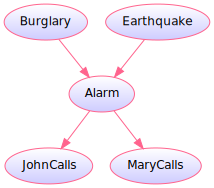

In [42]:
pgmpyToGraph(alarmModel)

### Case 1: Marginal Dependence (for Evidential Model)

$$
\color{Green}{ \text{Alarm (unobserved): }\;\;\;\;\;\;\;\;\; \text{Burglary} \longleftarrow \text{Alarm} \longleftarrow
\text{MaryCalls}}
$$

When the middle node `Alarm` is unknown / unobserved, there IS an active trail between `Burglary` and `MaryCalls`. In other words, there is a dependence between `Burglary` and `MaryCalls` when `Alarm` is unobserved. This means the probability of `Burglary` can influence probability of `MaryCalls` (and vice versa) when information about `Alarm`'s state is unknown.


$$
\color{Green}{ \text{Alarm (unobserved): }\;\;\;\;\;\;\;\;\; \text{Burglary} \longleftarrow \text{Alarm} \longleftarrow \text{JohnCalls}}
$$
When `Alarm`'s state is uknown, there is an active trail or dependency between `Burglary` and `JohnCalls`, so the probability of `Burglary` can influence the probability of `JohnCalls` (and vice versa) when `Alarm`'s state is unknown.

$$
\color{Green}{ \text{Alarm (unobserved): }\;\;\;\;\;\;\;\;\; \text{Earthquake} \longleftarrow \text{Alarm} \longleftarrow \text{MaryCalls}}
$$
When `Alarm`'s state is uknown, there is an active trail or dependency between `Earthquake` and `MaryCalls`, so the probability of `Earthquake` can influence the probability of `MaryCalls` (and vice versa) when `Alarm`'s state is unknown.

$$
\color{Green}{ \text{Alarm (unobserved): }\;\;\;\;\;\;\;\;\; \text{Earthquake} \longleftarrow \text{Alarm} \longleftarrow \text{JohnCalls}}
$$
When `Alarm`'s state is uknown, there is an active trail or dependency between `Earthquake` and `JohnCalls`, so the probability of `Earthquake` can influence the probability of `JohnCalls` (and vice versa) when `Alarm`'s state is unknown.

**Verify:** Using Active Trails

In [43]:
assert alarmModel.is_active_trail(start = MaryCalls.var, end = Burglary.var,  observed = None)
assert alarmModel.is_active_trail(start = MaryCalls.var, end = Earthquake.var, observed = None)
assert alarmModel.is_active_trail(start = JohnCalls.var, end = Burglary.var, observed = None)
assert alarmModel.is_active_trail(start = JohnCalls.var, end = Earthquake.var, observed = None)

showActiveTrails(model = alarmModel, variables = [MaryCalls.var, Burglary.var])

MaryCalls --> Earthquake
MaryCalls --> JohnCalls
MaryCalls --> Alarm
MaryCalls --> MaryCalls
MaryCalls --> Burglary
Burglary --> MaryCalls
Burglary --> JohnCalls
Burglary --> Alarm
Burglary --> Burglary


**Verify:** Using Probabilities (example of $B \leftarrow A \leftarrow J$ trail)
* **NOTE:** Evidential Reasoning For Evidential Model:

In [44]:
JB: DiscreteFactor = elim.query(variables = [Burglary.var], evidence = None)
print(JB)

  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 1624.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/4 [00:00<?, ?it/s] 

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: MaryCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 4/4 [00:00<00:00, 416.16it/s]

+-----------------+-----------------+
| Burglary        |   phi(Burglary) |
+=================+=================+
| Burglary(True)  |          0.0010 |
+-----------------+-----------------+
| Burglary(False) |          0.9990 |
+-----------------+-----------------+


In [45]:
JB_1 = elim.query(variables = [Burglary.var], evidence = {JohnCalls.var:'True'})
print(JB_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1055.97it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]     

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 482.47it/s]

+-----------------+-----------------+
| Burglary        |   phi(Burglary) |
+=================+=================+
| Burglary(True)  |          0.0163 |
+-----------------+-----------------+
| Burglary(False) |          0.9837 |
+-----------------+-----------------+


Below we see that when `JohnCalls` does not occur and no `Alarm` was observed, there is a lower probability of `Burglary`, compared to when neither `Alarm` nor `JohnCalls` were observed:
$$
P(\text{Burglary} = \text{True} \; | \; \text{JohnCalls} = \text{False}) = 0.9937
$$

In [46]:
JB_2 = elim.query(variables = [Burglary.var], evidence = {JohnCalls.var:'False'})
print(JB_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1234.34it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]     

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 276.28it/s]

+-----------------+-----------------+
| Burglary        |   phi(Burglary) |
+=================+=================+
| Burglary(True)  |          0.0002 |
+-----------------+-----------------+
| Burglary(False) |          0.9998 |
+-----------------+-----------------+


In [47]:
assert (JB.values != JB_1.values).all() and (JB.values != JB_2.values).all(), "Check there is dependency between Burglary and JohnCalls, when Alarm state is unobserved "

**Verify:** Using Probabilities (example of $E \leftarrow A \leftarrow J$ trail)
* **NOTE:** Evidential Reasoning For Evidential Model:

In [48]:
JE: DiscreteFactor = elim.query(variables = [Earthquake.var], evidence = None)
print(JE)

  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 1063.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: MaryCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/4 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 4/4 [00:00<00:00, 378.05it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0020 |
+-------------------+-------------------+
| Earthquake(False) |            0.9980 |
+-------------------+-------------------+


In [49]:
JE_1 = elim.query(variables = [Earthquake.var], evidence = {JohnCalls.var:'True'})
print(JE_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 928.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 560.46it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0114 |
+-------------------+-------------------+
| Earthquake(False) |            0.9886 |
+-------------------+-------------------+


Below we see that when `JohnCalls` does not occur and no `Alarm` was not observed, there is a lower probability of `Earthquake`, compared to when John did call and `Alarm` was not observed:
$$
P(\text{Earthquake} = \text{True} \; | \; \text{JohnCalls} = \text{False}) = 0.0019
$$

In [50]:
JE_2 = elim.query(variables = [Earthquake.var], evidence = {JohnCalls.var:'False'})
print(JE_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 788.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 449.61it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0015 |
+-------------------+-------------------+
| Earthquake(False) |            0.9985 |
+-------------------+-------------------+


In [51]:
assert (JE.values != JE_1.values).all() and (JE.values != JE_2.values).all(), "Check there is dependency between " \
                                                                              "JohnCalls and Earthquake, when Alarm " \
                                                                              "state is unobserved "




### Case 2: Conditional Independence (for Evidential Model)

$$
\color{DeepSkyBlue}{ \text{Alarm (observed): }\;\;\;\;\;\;\;\; \text{Burglary} \; \bot \; \text{MaryCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Burglary` and `MaryCalls`. In other words, `Burglary` and `MaryCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Burglary` won't influence probability of `MaryCalls` (and vice versa) when `Alarm`'s state is observed.

$$
\color{DeepSkyBlue}{ \text{Alarm (observed): }\;\;\;\;\;\;\;\; \text{Burglary} \; \bot \; \text{JohnCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Burglary` and `JohnCalls`. In other words, `Burglary` and `JohnCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Burglary` won't influence probability of `JohnCalls` (and vice versa) when `Alarm`'s state is observed.

$$
\color{DeepSkyBlue}{ \text{Alarm (observed): }\;\;\;\;\;\;\;\; \text{Earthquake} \; \bot \; \text{MaryCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Earthquake` and `MaryCalls`. In other words, `Earthquake` and `MaryCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Earthquake` won't influence probability of `MaryCalls` (and vice versa) when `Alarm`'s state is observed.

$$
\color{DeepSkyBlue}{ \text{Alarm (observed): }\;\;\;\;\;\;\;\; \text{Earthquake} \; \bot \; \text{JohnCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Earthquake` and `JohnCalls`. In other words, `Earthquake` and `JohnCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Earthquake` won't influence probability of `JohnCalls` (and vice versa) when `Alarm`'s state is observed.

**Verify:** Using Active Trails

In [52]:
assert not alarmModel.is_active_trail(start = MaryCalls.var, end = Burglary.var, observed = Alarm.var)
assert not alarmModel.is_active_trail(start = MaryCalls.var, end = Earthquake.var, observed = Alarm.var)
assert not alarmModel.is_active_trail(start = JohnCalls.var, end = Burglary.var, observed = Alarm.var)
assert not alarmModel.is_active_trail(start = JohnCalls.var, end = Earthquake.var, observed = Alarm.var)

showActiveTrails(model = alarmModel, variables = [JohnCalls.var, Earthquake.var], observed = Alarm.var)

JohnCalls --> JohnCalls
Earthquake --> Earthquake
Earthquake --> Burglary


**Verify:** Using Independencies (just the $(B \; \bot \; M \; | \; A)$ independence)

In [53]:
indepBurglary: IndependenceAssertion = Independencies([Burglary.var, MaryCalls.var, [Alarm.var]]).get_assertions()[0]; indepBurglary

indepMary: IndependenceAssertion = Independencies([MaryCalls.var, Burglary.var, [Alarm.var]]).get_assertions()[0]; indepMary

# Using the fact that closure returns independencies that are IMPLIED by the current independencies:
assert (str(indepMary) == '(MaryCalls _|_ Burglary | Alarm)' and
        indepMary in alarmModel.local_independencies(MaryCalls.var).closure().get_assertions()),  \
        "Check 1: Burglary and MaryCalls are independent once conditional on Alarm"

assert (str(indepBurglary) == '(Burglary _|_ MaryCalls | Alarm)' and
        indepBurglary in alarmModel.local_independencies(MaryCalls.var).closure().get_assertions()), \
        "Check 2: Burglary and MaryCalls are independent once conditional on Alarm"

alarmModel.local_independencies(MaryCalls.var).closure()

(MaryCalls _|_ JohnCalls | Alarm)
(MaryCalls _|_ Burglary | Alarm)
(MaryCalls _|_ Earthquake | Alarm, Burglary)
(MaryCalls _|_ Burglary | Earthquake, JohnCalls, Alarm)
(MaryCalls _|_ JohnCalls, Burglary | Earthquake, Alarm)
(MaryCalls _|_ Burglary | JohnCalls, Alarm)
(MaryCalls _|_ Earthquake, JohnCalls, Burglary | Alarm)
(MaryCalls _|_ Earthquake, JohnCalls | Alarm)
(MaryCalls _|_ Earthquake, Burglary | JohnCalls, Alarm)
(MaryCalls _|_ JohnCalls, Burglary | Alarm)
(MaryCalls _|_ JohnCalls | Alarm, Burglary)
(MaryCalls _|_ Earthquake, JohnCalls | Alarm, Burglary)
(MaryCalls _|_ Earthquake | Alarm)
(MaryCalls _|_ JohnCalls | Earthquake, Alarm, Burglary)
(MaryCalls _|_ Earthquake, Burglary | Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm, Burglary)
(MaryCalls _|_ Burglary | Earthquake, Alarm)
(MaryCalls _|_ JohnCalls | Earthquake, Alarm)

In [54]:
# See: MaryCalls and Burglary are conditionally independent on Alarm:
indepSynonymTable(model = alarmModel_brief, queryNode = 'M')



                   INDEPENDENCIES TABLE                  
Fancy Notation              .....     Regular Notation   
---------------------------------------------------------
(M _|_ {B ∩ J ∩ E} | A)     .....     (M _|_ B, J, E | A)
(M _|_ {B ∩ E ∩ J} | A)     .....     (M _|_ B, E, J | A)
(M _|_ {J ∩ B ∩ E} | A)     .....     (M _|_ J, B, E | A)
(M _|_ {J ∩ E ∩ B} | A)     .....     (M _|_ J, E, B | A)
(M _|_ {E ∩ B ∩ J} | A)     .....     (M _|_ E, B, J | A)
(M _|_ {E ∩ J ∩ B} | A)     .....     (M _|_ E, J, B | A)


**Verify:** Using Probabilities Method (just the $(E \; \bot \; J \; | \; A)$ independence)

The probability below is:
$$
\begin{array}{ll}
P(\text{Earthquake} = \text{True} \; | \; \text{Alarm} = \text{True})
&= P(\text{Earthquake} = \text{True} \; | \; \text{Alarm} = \text{True} \; \cap \; \text{JohnCalls} = \text{True})  \\
&= P(\text{Earthquake} = \text{True} \; | \; \text{Alarm} = \text{True} \; \cap \; \text{JohnCalls} = \text{False}) \\
&= 0.02
\end{array}
$$

In [55]:

# Case 1: Alarm = True
JAE: DiscreteFactor = elim.query(variables = [Earthquake.var], evidence = {Alarm.var: 'True'})
JAE_1 = elim.query(variables = [Earthquake.var], evidence = {Alarm.var: 'True', JohnCalls.var:'True'})
JAE_2 = elim.query(variables = [Earthquake.var], evidence = {Alarm.var: 'True', JohnCalls.var:'False'})

assert (JAE.values == JAE_1.values).all() and (JAE.values == JAE_2.values).all(), "Check: there is independence between Earthquake and JohnCalls when Alarm state is observed (Alarm = True)"

print(JAE)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1650.22it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 682.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1393.23it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 452.75it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1396.94it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 526.06it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.2310 |
+-------------------+-------------------+
| Earthquake(False) |            0.7690 |
+-------------------+-------------------+


The probability below is:
$$
\begin{array}{ll}
P(\text{Earthquake} = \text{True} \; | \; \text{Alarm} = \text{False})
&= P(\text{Earthquake} = \text{True} \; | \; \text{Alarm} = \text{False} \; \cap \; \text{JohnCalls} = \text{True})  \\
&= P(\text{Earthquake} = \text{True} \; | \; \text{Alarm} = \text{False} \; \cap \; \text{JohnCalls} = \text{False}) \\
&= 0.0017
\end{array}
$$

In [56]:
# Case 2: Alarm = False
JAE: DiscreteFactor = elim.query(variables = [Earthquake.var], evidence = {Alarm.var: 'False'})
JAE_1 = elim.query(variables = [Earthquake.var], evidence = {Alarm.var: 'False', JohnCalls.var:'True'})
JAE_2 = elim.query(variables = [Earthquake.var], evidence = {Alarm.var: 'False', JohnCalls.var:'False'})

assert (JAE.values == JAE_1.values).all() and (JAE.values == JAE_2.values).all(), "Check: there is independence between Earthquake and JohnCalls when Alarm state is observed (Alarm = False)"

print(JAE)







  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1615.47it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 688.38it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 166.36it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 689.40it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1729.25it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 813.24it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0014 |
+-------------------+-------------------+
| Earthquake(False) |            0.9986 |
+-------------------+-------------------+


### 3. Inter-Causal (?) Reasoning in the Alarm Model
For a common cause model $A \leftarrow B \rightarrow C$, there are two cases:
  * **Marginal Dependence:** ($B$ unknown): When $B$ is unknown / unobserved, there is an active trail between $A$ and $C$, meaning the probability of $A$ can influence probability of $C$ (and vice versa) when information about $B$'s state is unknown.
  * **Conditional Independence:** ($B$ fixed): When $B$ is fixed, there is NO active trail between $A$ and $C$, so they are independent. The probability of $A$ won't influence probability of $C$ (and vice versa) when $B$'s state is observed.

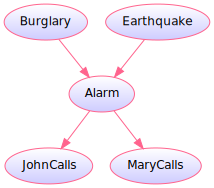

In [57]:
pgmpyToGraph(alarmModel)

### Case 1: Marginal Dependence (for Evidential Model)

$$
\color{Green}{ \text{Alarm (unobserved): }\;\;\;\;\;\;\;\;\; \text{JohnCalls} \longleftarrow \text{Alarm} \longleftarrow \text{MaryCalls}}
$$

When the parent node `Alarm` is unknown / unobserved, there IS an active trail between `JohnCalls` and `MaryCalls`. In other words, there is a dependence between `JohnCalls` and `MaryCalls` when `Alarm` is unobserved. This means the probability of `JohnCalls` can influence probability of `MaryCalls` (and vice versa) when information about `Alarm`'s state is unknown.

**Verify:** Using Active Trails

In [58]:
assert alarmModel.is_active_trail(start = JohnCalls.var, end = MaryCalls.var,  observed = None)

showActiveTrails(model = alarmModel, variables = [JohnCalls.var, MaryCalls.var])

JohnCalls --> Earthquake
JohnCalls --> JohnCalls
JohnCalls --> MaryCalls
JohnCalls --> Alarm
JohnCalls --> Burglary
MaryCalls --> Earthquake
MaryCalls --> JohnCalls
MaryCalls --> Alarm
MaryCalls --> MaryCalls
MaryCalls --> Burglary


**Verify:** Using Probabilities
* **NOTE:** Inter-Causal Reasoning For Common Cause Model:

In [59]:
JM: DiscreteFactor = elim.query(variables = [MaryCalls.var], evidence = None)
print(JM)

  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 2190.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/4 [00:00<?, ?it/s] 

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: Burglary:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Burglary: 100%|██████████| 4/4 [00:00<00:00, 540.69it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.0117 |
+------------------+------------------+
| MaryCalls(False) |           0.9883 |
+------------------+------------------+


Below we see that when `JohnCalls` and no `Alarm` was observed, there is a higher probability of `MaryCalls`, compared to when no `JohnCalls` nor `Alarm` were observed:
$$
P(\text{MaryCalls} = \text{True} \; | \; \text{JohnCalls} = \text{True}) = 0.6975
$$

In [60]:
JM_1 = elim.query(variables = [MaryCalls.var], evidence = {JohnCalls.var:'True'})
print(JM_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 914.19it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]  

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]   

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 463.95it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.0400 |
+------------------+------------------+
| MaryCalls(False) |           0.9600 |
+------------------+------------------+


Below we see that when `JohnCalls` does not occur and no `Alarm` was observed, there is a lower probability of `MaryCalls`, compared to when `JohnCalls` and `Alarm` was not observed:
$$
P(\text{MaryCalls} = \text{True} \; | \; \text{JohnCalls} = \text{False}) = 0.4369
$$

In [61]:
JM_2 = elim.query(variables = [MaryCalls.var], evidence = {JohnCalls.var:'False'})
print(JM_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1541.27it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]  

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]   

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 394.58it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.0102 |
+------------------+------------------+
| MaryCalls(False) |           0.9898 |
+------------------+------------------+


In [62]:
assert (JM.values != JM_1.values).all() and (JM.values != JM_2.values).all(), "Check: Marginal Dependence: there is dependency between MaryCalls and JohnCalls, when Alarm state is unobserved "

### Case 2: Conditional Independence (for Common Cause Model)

$$
\color{DeepSkyBlue}{ \text{Alarm (observed): }\;\;\;\;\;\;\;\; \text{JohnCalls} \; \bot \; \text{MaryCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `JohnCalls` and `MaryCalls`. In other words, `JohnCalls` and `MaryCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `JohnCalls` won't influence probability of `MaryCalls` (and vice versa) when `Alarm`'s state is observed.


**Verify:** Using Active Trails

In [63]:
assert not alarmModel.is_active_trail(start = JohnCalls.var, end = MaryCalls.var, observed = Alarm.var)

showActiveTrails(model = alarmModel, variables = [JohnCalls.var, MaryCalls.var], observed = Alarm.var)

JohnCalls --> JohnCalls
MaryCalls --> MaryCalls


**Verify:** Using Independencies

In [64]:
indepJohn: IndependenceAssertion = Independencies([JohnCalls.var, MaryCalls.var, [Alarm.var]]).get_assertions()[0]; indepJohn

indepMary: IndependenceAssertion = Independencies([MaryCalls.var, JohnCalls.var, [Alarm.var]]).get_assertions()[0]; indepMary


# Using the fact that closure returns independencies that are IMPLIED by the current independencies:
assert (str(indepMary) == '(MaryCalls _|_ JohnCalls | Alarm)' and
        indepMary in alarmModel.local_independencies(MaryCalls.var).closure().get_assertions()),  \
        "Check 1: MaryCalls and JohnCalls are independent once conditional on Alarm"

alarmModel.local_independencies(MaryCalls.var).closure()

(MaryCalls _|_ JohnCalls | Alarm)
(MaryCalls _|_ Burglary | Alarm)
(MaryCalls _|_ Earthquake | Alarm, Burglary)
(MaryCalls _|_ Burglary | Earthquake, JohnCalls, Alarm)
(MaryCalls _|_ JohnCalls, Burglary | Earthquake, Alarm)
(MaryCalls _|_ Burglary | JohnCalls, Alarm)
(MaryCalls _|_ Earthquake, JohnCalls, Burglary | Alarm)
(MaryCalls _|_ Earthquake, JohnCalls | Alarm)
(MaryCalls _|_ Earthquake, Burglary | JohnCalls, Alarm)
(MaryCalls _|_ JohnCalls, Burglary | Alarm)
(MaryCalls _|_ JohnCalls | Alarm, Burglary)
(MaryCalls _|_ Earthquake, JohnCalls | Alarm, Burglary)
(MaryCalls _|_ Earthquake | Alarm)
(MaryCalls _|_ JohnCalls | Earthquake, Alarm, Burglary)
(MaryCalls _|_ Earthquake, Burglary | Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm, Burglary)
(MaryCalls _|_ Burglary | Earthquake, Alarm)
(MaryCalls _|_ JohnCalls | Earthquake, Alarm)

In [65]:
assert (str(indepJohn) == '(JohnCalls _|_ MaryCalls | Alarm)' and
        indepJohn in alarmModel.local_independencies(JohnCalls.var).closure().get_assertions()), \
        "Check 2: JohnCalls and MaryCalls are independent once conditional on Alarm"

alarmModel.local_independencies(MaryCalls.var).closure()

(MaryCalls _|_ JohnCalls | Alarm)
(MaryCalls _|_ Burglary | Alarm)
(MaryCalls _|_ Earthquake | Alarm, Burglary)
(MaryCalls _|_ Burglary | Earthquake, JohnCalls, Alarm)
(MaryCalls _|_ JohnCalls, Burglary | Earthquake, Alarm)
(MaryCalls _|_ Burglary | JohnCalls, Alarm)
(MaryCalls _|_ Earthquake, JohnCalls, Burglary | Alarm)
(MaryCalls _|_ Earthquake, JohnCalls | Alarm)
(MaryCalls _|_ Earthquake, Burglary | JohnCalls, Alarm)
(MaryCalls _|_ JohnCalls, Burglary | Alarm)
(MaryCalls _|_ JohnCalls | Alarm, Burglary)
(MaryCalls _|_ Earthquake, JohnCalls | Alarm, Burglary)
(MaryCalls _|_ Earthquake | Alarm)
(MaryCalls _|_ JohnCalls | Earthquake, Alarm, Burglary)
(MaryCalls _|_ Earthquake, Burglary | Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm, Burglary)
(MaryCalls _|_ Burglary | Earthquake, Alarm)
(MaryCalls _|_ JohnCalls | Earthquake, Alarm)

In [66]:
# See: MaryCalls and JohnCalls are conditionally independent on Alarm:
indepSynonymTable(model = alarmModel_brief, queryNode = 'M')

                   INDEPENDENCIES TABLE                  
Fancy Notation              .....     Regular Notation   
---------------------------------------------------------
(M _|_ {B ∩ J ∩ E} | A)     .....     (M _|_ B, J, E | A)
(M _|_ {B ∩ E ∩ J} | A)     .....     (M _|_ B, E, J | A)
(M _|_ {J ∩ B ∩ E} | A)     .....     (M _|_ J, B, E | A)
(M _|_ {J ∩ E ∩ B} | A)     .....     (M _|_ J, E, B | A)
(M _|_ {E ∩ B ∩ J} | A)     .....     (M _|_ E, B, J | A)
(M _|_ {E ∩ J ∩ B} | A)     .....     (M _|_ E, J, B | A)


In [67]:
indepSynonymTable(model = alarmModel_brief, queryNode = 'J')

                   INDEPENDENCIES TABLE                  
Fancy Notation              .....     Regular Notation   
---------------------------------------------------------
(J _|_ {B ∩ M ∩ E} | A)     .....     (J _|_ B, M, E | A)
(J _|_ {B ∩ E ∩ M} | A)     .....     (J _|_ B, E, M | A)
(J _|_ {M ∩ B ∩ E} | A)     .....     (J _|_ M, B, E | A)
(J _|_ {M ∩ E ∩ B} | A)     .....     (J _|_ M, E, B | A)
(J _|_ {E ∩ B ∩ M} | A)     .....     (J _|_ E, B, M | A)
(J _|_ {E ∩ M ∩ B} | A)     .....     (J _|_ E, M, B | A)


**Verify:** Using Probabilities Method

The probability below is:
$$
\begin{array}{ll}
P(\text{MaryCalls} = \text{True} \; | \; \text{Alarm} = \text{True})
&= P(\text{MaryCalls} = \text{True} \; | \; \text{Alarm} = \text{True} \; \cap \; \text{JohnCalls} = \text{True})  \\
&= P(\text{MaryCalls} = \text{True} \; | \; \text{Alarm} = \text{True} \; \cap \; \text{JohnCalls} = \text{False}) \\
&= 0.7
\end{array}
$$

In [68]:

# Case 1: Alarm = True
JAM: DiscreteFactor = elim.query(variables = [MaryCalls.var], evidence = {Alarm.var: 'True'})
JAM_1 = elim.query(variables = [MaryCalls.var], evidence = {Alarm.var: 'True', JohnCalls.var:'True'})
JAM_2 = elim.query(variables = [MaryCalls.var], evidence = {Alarm.var: 'True', JohnCalls.var:'False'})

assert (JAM.values == JAM_1.values).all() and (JAM.values == JAM_2.values).all(), "Check: there is independence between MaryCalls and JohnCalls when Alarm state is observed (Alarm = True)"

print(JAM)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1259.17it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 690.31it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 743.67it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]  

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 430.63it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 999.71it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]  

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 398.62it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.7000 |
+------------------+------------------+
| MaryCalls(False) |           0.3000 |
+------------------+------------------+


The probability below is:
$$
\begin{array}{ll}
P(\text{MaryCalls} = \text{True} \; | \; \text{Alarm} = \text{False})
&= P(\text{MaryCalls} = \text{True} \; | \; \text{Alarm} = \text{False} \; \cap \; \text{JohnCalls} = \text{True})  \\
&= P(\text{MaryCalls} = \text{True} \; | \; \text{Alarm} = \text{False} \; \cap \; \text{JohnCalls} = \text{False}) \\
&= 0.7
\end{array}
$$

In [69]:

# Case 2: Alarm = False
JAM: DiscreteFactor = elim.query(variables = [MaryCalls.var], evidence = {Alarm.var: 'False'})
JAM_1 = elim.query(variables = [MaryCalls.var], evidence = {Alarm.var: 'False', JohnCalls.var:'True'})
JAM_2 = elim.query(variables = [MaryCalls.var], evidence = {Alarm.var: 'False', JohnCalls.var:'False'})

assert (JAM.values == JAM_1.values).all() and (JAM.values == JAM_2.values).all(), "Check: there is independence between MaryCalls and JohnCalls when Alarm state is observed (Alarm = False)"

print(JAM)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 957.02it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 406.27it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1428.33it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]  

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 433.74it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 974.85it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]  

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 476.98it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.0100 |
+------------------+------------------+
| MaryCalls(False) |           0.9900 |
+------------------+------------------+


In [70]:
# Symmetry:
MAJ: DiscreteFactor = elim.query(variables = [JohnCalls.var], evidence = {Alarm.var: 'False'})
MAJ_1 = elim.query(variables = [JohnCalls.var], evidence = {Alarm.var: 'False', MaryCalls.var:'True'})
MAJ_2 = elim.query(variables = [JohnCalls.var], evidence = {Alarm.var: 'False', MaryCalls.var:'False'})

assert (MAJ.values == MAJ_1.values).all() and (MAJ.values == MAJ_2.values).all(), "Check: there is independence between MaryCalls and JohnCalls when Alarm state is observed (Alarm = False)"

print(MAJ)




  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1626.12it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 533.29it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1062.52it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]  

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 532.78it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1104.49it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]  

Eliminating: Burglary: 100%|██████████| 2/2 [00:00<00:00, 620.46it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.0500 |
+------------------+------------------+
| JohnCalls(False) |           0.9500 |
+------------------+------------------+


### 4. Inter-Causal Reasoning in the Alarm Model
For a common evidence model $A \rightarrow B \leftarrow C$, there are two cases:
  * **Marginal Independence:** ($B$ unknown): When $B$ is unknown / unobserved, there is NO active trail between $A$ and $C$; they are independent. The probability of $A$ won't influence probability of $C$ (and vice versa) when $B$'s state is unknown.
  * **Conditional Dependence:** ($B$ fixed): When $B$ is fixed, there IS an active trail between $A$ and $C$, meaning the probability of $A$ can influence probability of $C$ (and vice versa) when information about $B$ is observed / fixed.

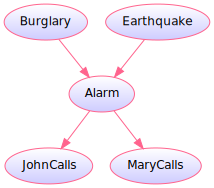

In [71]:
pgmpyToGraph(alarmModel)

### Case 1: Marginal Independence (for Common Evidence Model)

$$
\color{DeepSkyBlue}{ \text{Alarm (observed): }\;\;\;\;\;\;\;\; \text{Burglary} \; \bot \; \text{Earthquake} \; | \; \text{Alarm}}
$$

When the effect node `Alarm` is unknown / unobserved, there is NO an active trail between `Burglary` and `Earthquake`. In other words, there is a local marginal independence between `Burglary` and `Earthquake` when `Alarm` is unobserved. This means the probability of `Burglary` won't influence the probability of `Earthquake` (and vice versa) when `Alarm`'s state is unknown.


**Verify:** Using Active Trails

In [72]:
assert not alarmModel.is_active_trail(start = Burglary.var, end = Earthquake.var, observed = None)

showActiveTrails(model = alarmModel, variables = [Burglary.var, Earthquake.var])

Burglary --> MaryCalls
Burglary --> JohnCalls
Burglary --> Alarm
Burglary --> Burglary
Earthquake --> MaryCalls
Earthquake --> Earthquake
Earthquake --> JohnCalls
Earthquake --> Alarm


**Verify:** Using Independencies

In [73]:
indepBurgEarth = Independencies([Burglary.var, Earthquake.var])

assert indepBurgEarth == alarmModel.local_independencies(Burglary.var), 'Check 1: Burglary and Earthquake are marginally independent'

assert indepBurgEarth == alarmModel.local_independencies(Earthquake.var), 'Check 2: Burglary and Earthquake are marginally independent'


# See: MaryCalls and Burglary are marginally independent :
print(indepSynonymTable(model = alarmModel, queryNode = Burglary.var))
print(indepSynonymTable(model = alarmModel, queryNode = Earthquake.var))

                       INDEPENDENCIES TABLE                      
Fancy Notation                .....     Regular Notation         
-----------------------------------------------------------------
(Burglary _|_ Earthquake)     .....     (Burglary _|_ Earthquake)
None
                       INDEPENDENCIES TABLE                      
Fancy Notation                .....     Regular Notation         
-----------------------------------------------------------------
(Earthquake _|_ Burglary)     .....     (Earthquake _|_ Burglary)
None


**Verify:** Using Probabilities Method

The probability below is:
$$
\begin{array}{ll}
P(\text{Earthquake} = \text{True})
&= P(\text{Earthquake} = \text{True} \; | \; \text{Burglary} = \text{True})  \\
&= P(\text{Earthquake} = \text{True} \; | \; \text{Burglary} = \text{False}) \\
&= 0.7
\end{array}
$$

In [74]:

BE: DiscreteFactor = elim.query(variables = [Earthquake.var], evidence = None)
BE_1 = elim.query(variables = [Earthquake.var], evidence = {Burglary.var:'True'})
BE_2 = elim.query(variables = [Earthquake.var], evidence = {Burglary.var: 'False'})

# Using np.allclose instead of exact equals sign (there must be some numerical inconsistency ... otherwise they wouldn't be different at all! BAE.values[0] = 0.0019999999 while BAE_1.values[0] = 0.002)
assert np.allclose(BE.values, BE_1.values) and np.allclose(BE.values, BE_2.values), "Check: there is marginal independence between Earthquake and Burglary when Alarm state is NOT observed"

print(BE)



  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 1877.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: MaryCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/4 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 4/4 [00:00<00:00, 437.39it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 2236.56it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 589.20it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1719.68it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 648.54it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0020 |
+-------------------+-------------------+
| Earthquake(False) |            0.9980 |
+-------------------+-------------------+


### Case 2: Conditional Dependence (for Common Evidence Model)

$$
\color{Green}{ \text{Alarm (unobserved): }\;\;\;\;\;\;\;\;\; \text{Burglary} \longleftarrow \text{Alarm} \longrightarrow \text{Earthquake}}
$$
When the `Alarm`'s state is known (fixed / observed), then there IS an active trail between `Burglary` and `Earthquake`. In other words, `Burglary` and `Earthquake` are dependent when `Alarm`'s state is observed. This means the probability of `Burglary` can influence probability of `Earthquake` (and vice versa) when `Alarm`'s state is observed.

**Verify:** Using Active Trails

In [75]:
assert alarmModel.is_active_trail(start = Burglary.var, end = Earthquake.var,  observed = Alarm.var)

showActiveTrails(model = alarmModel, variables = [Burglary.var, Earthquake.var], observed = Alarm.var)

Burglary --> Earthquake
Burglary --> Burglary
Earthquake --> Earthquake
Earthquake --> Burglary


**Verify:** Using Probabilities
* **NOTE:** Inter-Causal Reasoning For Common Evidence Model:

In [76]:

# Case 1: Alarm = True
BAE: DiscreteFactor = elim.query(variables = [Earthquake.var], evidence = {Alarm.var: 'True'})
print(BAE)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1349.95it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 589.47it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.2310 |
+-------------------+-------------------+
| Earthquake(False) |            0.7690 |
+-------------------+-------------------+


In [77]:
BAE_1: DiscreteFactor = elim.query(variables = [Earthquake.var], evidence = {Burglary.var:'True', Alarm.var: 'True'})
print(BAE_1)

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1167.68it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 712.05it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0020 |
+-------------------+-------------------+
| Earthquake(False) |            0.9980 |
+-------------------+-------------------+


Below we see that when there was no`Burglary` (cause) and `Alarm` rang, there is a higher probability of `Earthquake` (other cause) compared to when there was a `Burglary` and `Alarm` rang:
$$
P(\text{Earthquake} = \text{True} \; | \; \text{Burglary} = \text{False} \; \cap \; \text{Alarm} = \text{True}) = 0.3676
$$
* NOTE: This is like in page 41 of Korb book (inverse of "explaining away")

In [78]:
BAE_2: DiscreteFactor = elim.query(variables = [Earthquake.var], evidence = {Burglary.var:'False', Alarm.var: 'True'})
print(BAE_2)

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1078.37it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 428.30it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.3676 |
+-------------------+-------------------+
| Earthquake(False) |            0.6324 |
+-------------------+-------------------+


In [79]:
assert (BAE_2.values != BAE.values).all(), 'Check: there is dependency between Earthquake and Burglary when Alarm state is observed (True)'

The probability below is:
$$
P(\text{Earthquake} = \text{True} \; | \;\text{Alarm} = \text{False}) = 0.0017
$$

In [80]:
# Case 2: Alarm = False
BAE: DiscreteFactor = elim.query(variables = [Earthquake.var], evidence = {Alarm.var: 'False'})
print(BAE)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1158.43it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: Burglary: 100%|██████████| 3/3 [00:00<00:00, 618.87it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0014 |
+-------------------+-------------------+
| Earthquake(False) |            0.9986 |
+-------------------+-------------------+


The probability below is:
$$
P(\text{Earthquake} = \text{True} \; | \; \text{Burglary} = \text{True} \; \cap \; \text{Alarm} = \text{False}) = 0.0017
$$

In [81]:
BAE_1: DiscreteFactor = elim.query(variables = [Earthquake.var], evidence = {Burglary.var:'True', Alarm.var: 'False'})
print(BAE_1)

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 968.10it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 781.57it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0017 |
+-------------------+-------------------+
| Earthquake(False) |            0.9983 |
+-------------------+-------------------+


Below we see that when there was no `Burglary` (cause) and `Alarm` did not ring, there is a lower probability of `Earthquake` (other cause) compared to when there was a `Burglary` and `Alarm` didn't ring:
$$
P(\text{Earthquake} = \text{True} \; | \; \text{Burglary} = \text{False} \; \cap \; \text{Alarm} = \text{False}) = 0.0014
$$

In [82]:
BAE_2: DiscreteFactor = elim.query(variables = [Earthquake.var], evidence = {Burglary.var:'False', Alarm.var: 'False'})
print(BAE_2)

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1187.18it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 689.91it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0014 |
+-------------------+-------------------+
| Earthquake(False) |            0.9986 |
+-------------------+-------------------+


In [83]:
assert (BAE_2.values != BAE.values).all(), 'Check: there is dependency between Earthquake and Burglary when Alarm state is observed (False)'